In [1]:
import multiprocessing as mp
import cv2
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score
from sklearn.kernel_approximation import Nystroem
from sklearn import svm
from joblib import Parallel, delayed, cpu_count
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from skimage.feature import hog
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pickle
import time

plt.rcParams["figure.figsize"] = (15.0, 12.0)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams["figure.figsize"] = (15.0, 12.0)  # set default size of plots

In [3]:
with open("cache/training/neg_samples.pkl", "rb") as f:
    neg_samples = pickle.load(f)
with open("cache/training/waldo.pkl", "rb") as f:
    pos_waldo = pickle.load(f)
with open("cache/training/wenda.pkl", "rb") as f:
    pos_wenda = pickle.load(f)
with open("cache/training/wizard.pkl", "rb") as f:
    pos_wizard = pickle.load(f)


 ## Compute HOG feature descriptor for all samples

Sample image shape (128, 128), feature vector shape (12800,)
Sample image shape (128, 128), feature vector shape (12800,)
Sample image shape (128, 128), feature vector shape (12800,)
Sample image shape (128, 128), feature vector shape (12800,)


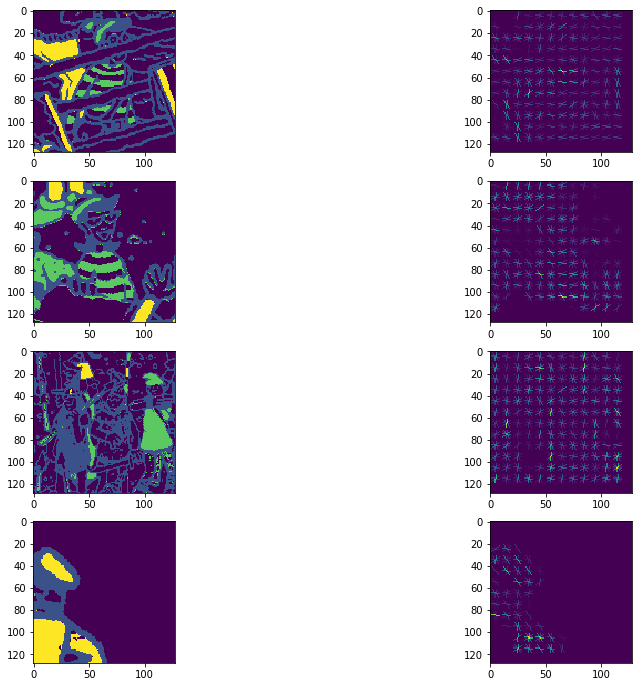

In [4]:

# DESCRIPTOR CONFIG
ORIENTATIONS = 8
PIXELS_PER_CELL = (10,10)
CELLS_PER_BLOCK = (5,5)

# viualize the descriptor once for each class
for i, s in enumerate([pos_waldo[0], pos_wenda[0], pos_wizard[0], neg_samples[0]]):
    feature, hog_image = hog(
        s,
        orientations=ORIENTATIONS,
        pixels_per_cell=PIXELS_PER_CELL,
        cells_per_block=CELLS_PER_BLOCK,
        visualize=True,
        multichannel=False,
    )
    print(
        "Sample image shape {}, feature vector shape {}".format(s.shape, feature.shape)
    )
    plt.subplot(4, 2, 2 * i + 1)
    plt.imshow(s)
    plt.subplot(4, 2, 2 * i + 2)
    plt.imshow(hog_image)

plt.show()



In [5]:
LABELS = {"waldo": 0, "wenda": 1, "wizard": 2, "negative": 3}


def hog_descriptor(samples, parallel=False):
    if parallel:
        return np.array(Parallel(n_jobs=cpu_count())(delayed(hog)(s,
                                                        orientations=ORIENTATIONS,
                                                        pixels_per_cell=PIXELS_PER_CELL,
                                                        cells_per_block=CELLS_PER_BLOCK,
                                                        visualize=False,
                                                        multichannel=False) for s in samples))
    else:
        return np.array(
            [
                hog(
                    s,
                    orientations=ORIENTATIONS,
                    pixels_per_cell=PIXELS_PER_CELL,
                    cells_per_block=CELLS_PER_BLOCK,
                    visualize=False,
                    multichannel=False,
                )
                for s in samples
            ]
    )


# transform samples into feature space
pf_wa = hog_descriptor(pos_waldo, parallel=True)
pf_we = hog_descriptor(pos_wenda, parallel=True)
pf_wi = hog_descriptor(pos_wizard, parallel=True)
nf_s = hog_descriptor(neg_samples, parallel=True)

X = np.concatenate((pf_wa, pf_we, pf_wi, nf_s), axis=0)
Y = np.concatenate(
    (
        np.full(pf_wa.shape[0], LABELS["waldo"]),
        np.full(pf_we.shape[0], LABELS["wenda"]),
        np.full(pf_wi.shape[0], LABELS["wizard"]),
        np.full(nf_s.shape[0], LABELS["negative"]),
    ),
    axis=0,
)

x_train, y_train = X, Y


In [6]:
print("training data shape: examples: {}, labels: {}".format(x_train.shape, y_train.shape))

pos = pf_wa.shape[0] + pf_we.shape[0] + pf_wi.shape[0]
neg = nf_s.shape[0]
tot = X.shape[0]

print('waldo: {} {:2.2f}%'.format(pf_wa.shape[0], pf_wa.shape[0]*100/tot))
print('wenda: {} {:2.2f}%'.format(pf_we.shape[0], pf_we.shape[0]*100/tot))
print('wizard: {} {:2.2f}%'.format(pf_wi.shape[0], pf_wi.shape[0]*100/tot))
print('negative: {} {:2.2f}%'.format(nf_s.shape[0], nf_s.shape[0]*100/tot))


print('positive examples:\t{}\t{:2.2f}% \nnegative examples\t{}\t{:2.2f}%'.format(pos, pos*100/tot, neg, neg*100/tot))


training data shape: examples: (13467, 12800), labels: (13467,)
waldo: 124 0.92%
wenda: 36 0.27%
wizard: 24 0.18%
negative: 13283 98.63%
positive examples:	184	1.37% 
negative examples	13283	98.63%


 ## Train Support Vector Machine Classifier (SVC)

In [ ]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [1e-3, 0.01, 0.1, 10, 100, 1000],
    'gamma': [1e-4, 1e-3, 0.01, 0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear'],
}


print(x_train.shape, y_train.shape)

# This uses hyperparameter search to find the best model.
# Therefore it can be quite slow!
#clf = GridSearchCV(svm.SVC(class_weight='balanced', random_state=0, decision_function_shape='ovo', probability=True),
#                  param_grid, refit=True, n_jobs=-1, cv=5)

clf = svm.SVC(C=100, gamma=0.01, kernel='rbf', class_weight='balanced', random_state=0, decision_function_shape='ovo', probability=True)

clf.fit(x_train, y_train)


#print('best parameters:')
#print(clf.best_params_)
#print(clf.best_estimator_)

# save model to disk
with open("./Linear_SVM_V3.pkl", "wb") as f:
    pickle.dump(clf, f)


In [7]:
with open("./Linear_SVM_V3.pkl", "rb") as f:
    clf = pickle.load(f)

 ## Evaluate Classifier

In [8]:
# load testing data
with open("cache/testing/waldo.pkl", "rb") as f:
    test_waldo = pickle.load(f)
with open("cache/testing/wenda.pkl", "rb") as f:
    test_wenda = pickle.load(f)
with open("cache/testing/wizard.pkl", "rb") as f:
    test_wizard = pickle.load(f)
with open("cache/testing/neg_samples.pkl", "rb") as f:
    test_neg_samples = pickle.load(f)[:30]

# transform samples into feature space
test_waldo = hog_descriptor(test_waldo, parallel=True)
test_wenda = hog_descriptor(test_wenda, parallel=True)
test_wizard = hog_descriptor(test_wizard, parallel=True)
test_neg_samples = hog_descriptor(test_neg_samples, parallel=True)

x_test = np.concatenate((test_waldo, test_wenda, test_wizard, test_neg_samples), axis=0)
y_test = np.concatenate(
    (
        np.full(test_waldo.shape[0], LABELS["waldo"]),
        np.full(test_wenda.shape[0], LABELS["wenda"]),
        np.full(test_wizard.shape[0], LABELS["wizard"]),
        np.full(test_neg_samples.shape[0], LABELS["negative"]),
    ),
    axis=0,
)


In [9]:
from sklearn.metrics import classification_report
print(classification_report(y_test, clf.predict(x_test),
                           target_names=LABELS))

              precision    recall  f1-score   support

       waldo       1.00      0.69      0.82        13
       wenda       0.80      0.57      0.67         7
      wizard       0.00      0.00      0.00         3
    negative       0.77      1.00      0.87        30

    accuracy                           0.81        53
   macro avg       0.64      0.57      0.59        53
weighted avg       0.79      0.81      0.78        53



/Users/databook/miniconda3/envs/cvpr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Display confusion matrix

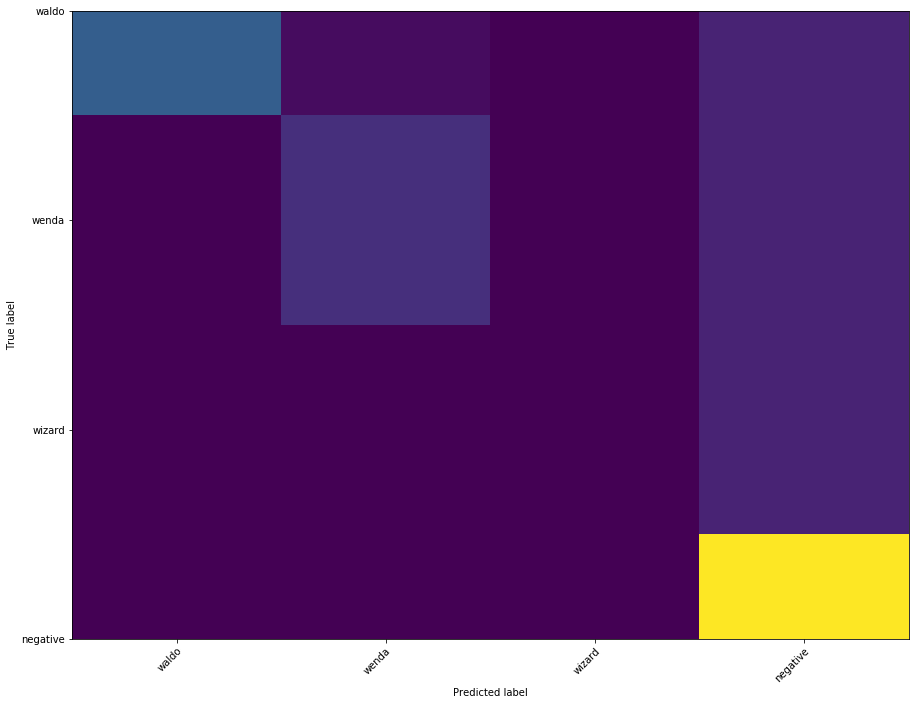

In [10]:
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(x_test)
conf_matrix = confusion_matrix(y_test, y_pred)

ax = plt.subplot()
ax.imshow(conf_matrix, interpolation='nearest')
ax.set(xticks=np.arange(conf_matrix.shape[1]),
       yticks=np.arange(conf_matrix.shape[0]),
       xticklabels=LABELS, yticklabels=LABELS,
       ylabel='True label',
       xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.show()

 ## Try the classifier on one sample image

In [12]:
with open('cache/waldo45.pkl', 'rb') as f:
    sample = pickle.load(f)
    
with open('cache/KMeans.pkl', 'rb') as f:
    kmeans = pickle.load(f)
    K = 5
    
def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d), dtype=np.uint8)
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i,j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

def process_img(img):
    w,h,d = img.shape
    labels = kmeans.predict(np.reshape(img, (w*h,d)))
    
    white_idx =  np.argmin([np.linalg.norm(np.array([253, 253, 253]) - c) for c in kmeans.cluster_centers_])
    other_col_idx = np.argmin([np.linalg.norm(np.array([182,159,154]) - c) for c in kmeans.cluster_centers_])
    labels[labels == other_col_idx] = white_idx
    
    c = (np.arange(0,K) * 255 / (K-1)).astype(np.uint8)[np.newaxis].T
    cluster_centers = np.hstack([c,c,c])
    return recreate_image(cluster_centers, labels, w,h)[:,:,0]

img = sample['img']

In [13]:
def bbx_iou(bbx1, bbx2):
    if bbx1[0] >= bbx1[2] or bbx1[1] >= bbx1[3] or bbx2[0] >= bbx2[2] or bbx2[1] >= bbx2[3]:
        return 0
    
    # determine the coordinates of the intersection rectangle
    x_left = max(bbx1[0], bbx2[0])
    y_top = max(bbx1[1], bbx2[1])
    x_right = min(bbx1[2], bbx2[2])
    y_bottom = min(bbx1[3], bbx2[3])
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    # compute the area of both AABBs
    bbx1_area = (bbx1[2] - bbx1[0]) * (bbx1[3] - bbx1[1])
    bbx2_area = (bbx2[2] - bbx2[0]) * (bbx2[3] - bbx2[1])
    
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bbx1_area + bbx2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

def non_max_suppression(detections):
    groups = [[detections[0]]]
    for d in detections:
        for idx, g in enumerate(groups):
            if np.max([bbx_iou(d, x) for x in g]) > 0:
                groups[idx].append(d)
            else:
                groups.append([d])
    detections = []
    for g in groups:
        detections.append(g[np.argmax(x[-1] for x in g)])
    return detections

In [14]:
#img = cv2.cvtColor(cv2.imread("datasets/JPEGImages/018.jpg"), cv2.COLOR_BGR2RGB)
def draw_bbox(ax, name, box, col='r'):
    r = patches.Rectangle((box[0], box[1]), 
                          box[2] - box[0],
                          box[3] - box[1],
                          linewidth=3,
                          edgecolor=col,
                          facecolor='none')
    ax.add_patch(r)
    ax.text(box[0], box[1], name,
            bbox={'facecolor': col, 'linewidth': 0})

def draw_annotation(ax, classes):
    for idx, cl in enumerate(classes):
        col = 'g'
        for box in cl['bounds']:
            draw_bbox(ax, cl['name'], box, col)

def dict_invert(key, d):
    return set(k for k, v in d.items() if v == key).pop()


def _transform_feature(img, ymin, ymax, xmin, xmax):
    if np.var(np.random.choice(img[ymin:ymax, xmin:xmax, 0].ravel(), 500)) < 5000:
        return (0,0,0,0, None)
    window = cv2.resize(img[ymin:ymax, xmin:xmax], dsize=(128, 128), interpolation=cv2.INTER_LINEAR)
    return (ymin, ymax, xmin, xmax, hog_descriptor([process_img(window)]))

def _predict(ymin, ymax, xmin, xmax, feat_vect):
    if feat_vect is None:
        #print('.', end='')
        return None
    
    label = clf.predict(feat_vect)
    
    if LABELS['negative'] not in label:
        proba = clf.predict_proba(feat_vect)[0]
        p_ratio = proba[label[0]] / np.sort(proba)[-2]
        
        print(ymin, ymax, xmin, xmax, dict_invert(label[0], LABELS), proba[label[0]], p_ratio)
        return [ymin, ymax, xmin, xmax, label, p_ratio]
    return None

def detect_img(img):
    img_y, img_x = img.shape[:2]
    size = 128
    print('performing detection on image of size {} with window size {}'.format(img.shape, size))
        
    with mp.Pool(mp.cpu_count()) as p:
        args = []
        for scale in range(1, 6):
            window_size = int(size * scale)
            for y in range(0, img_y - window_size, window_size // 4):
                for x in range(0, img_x - window_size, window_size // 4):
                    args.append((img, y, y + window_size, x, x + window_size))

        print("transforming image windows into feature space")

        feature_vectors = p.starmap(_transform_feature, args)

        print('... done')
        print("detecting classes for windows")
        print('detections:')
        
        detections = p.starmap(_predict, feature_vectors)
        
        
        omitted = 0
        detections_ = []
        for d in detections:
            if d: detections_.append(d)
            else: omitted += 1
        detections = detections_   

            
    #print('median confidence {}%'.format(np.median(confidence, axis = 0)*100))
    
    print('omitted {:2f}% of windows'.format(omitted / len(feature_vectors)*100))
    print('evaluated {} windows'.format(len(feature_vectors)))
    
    #detections = non_max_suppression(detections)
    print('num classes after non_max_supp: {}'.format(len(detections)))
    
    ax = plt.subplot(1, 1, 1)
    plt.imshow(img)
    # draw gound truth
    #draw_annotation(ax, sample['classes'])

    # draw detections
    for d in detections:
        w, h = d[3] - d[2], d[1] - d[0]
        p = patches.Rectangle((d[2], d[0]), w, h, edgecolor="r", facecolor="none", linewidth=3)
        ax.text(d[2], d[0], '{}: {:2.1f}'.format(dict_invert(d[4], LABELS), d[5]),
            bbox={'facecolor': 'r', 'linewidth': 0},
           fontsize='small')
        ax.add_patch(p)
        
    plt.show()
    return np.array(detections)
    

performing detection on image of size (1425, 1200, 3) with window size 128
transforming image windows into feature space
... done
detecting classes for windows
detections:
1088 1216 0 128 waldo 0.6429898340657088 2.101220358885645
1088 1216 384 512 waldo 0.5575739763189674 1.5582962804085057
1152 1280 960 1088 waldo 0.6829372462187406 2.5656486247446
omitted 99.837486% of windows
evaluated 1846 windows
num classes after non_max_supp: 3


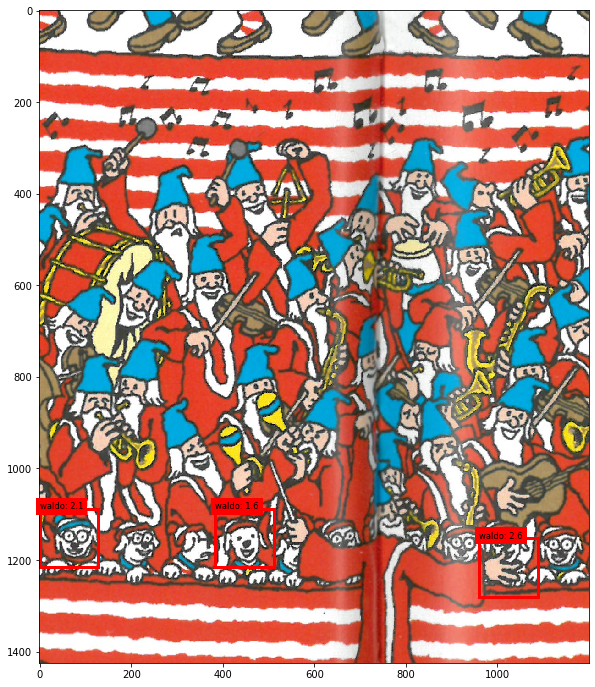

performing detection on image of size (671, 681, 3) with window size 128
transforming image windows into feature space
... done
detecting classes for windows
detections:
omitted 100.000000% of windows
evaluated 372 windows
num classes after non_max_supp: 0


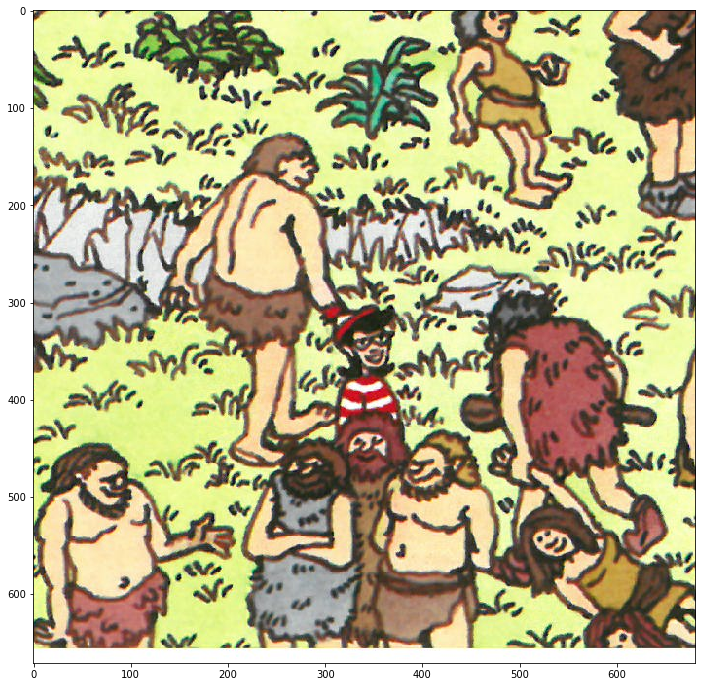

performing detection on image of size (2002, 1881, 3) with window size 128
transforming image windows into feature space
... done
detecting classes for windows
detections:
832 960 896 1024 waldo 0.8344439355236408 7.967291985588046
864 992 896 1024 waldo 0.9290853171571254 27.115731882048422
768 1024 832 1088 waldo 0.6291367328209123 1.914526053162488
768 1152 768 1152 waldo 0.5948446715093162 1.8053940847018712
864 1248 768 1152 waldo 0.5790896446928273 1.81489844141234
896 1152 832 1088 waldo 0.5704897084578572 2.0818919538501377
800 1440 640 1280 waldo 0.7073838206519941 4.456076541284223
omitted 99.842661% of windows
evaluated 4449 windows
num classes after non_max_supp: 7


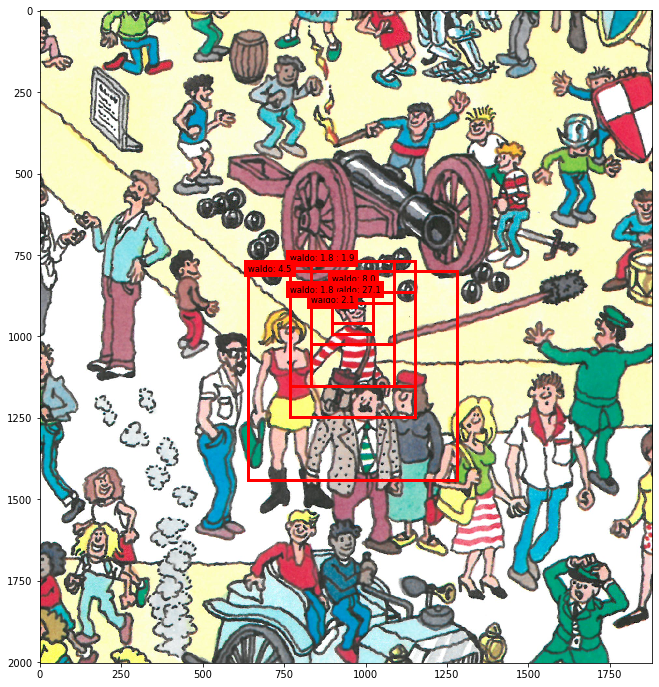

times [10.737426609999602, 3.2596054089999598, 24.344931168999665]
ious [0.0, 0, 0.3772882259991649]
mean time 12.780654395999742
mean iou 0.12576274199972162


In [20]:
## this is adapted from https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation
def _bbx_iou(bbx1, bbx2):
    assert bbx1['x1'] < bbx1['x2']
    assert bbx1['y1'] < bbx1['y2']
    assert bbx2['x1'] < bbx2['x2']
    assert bbx2['y1'] < bbx2['y2']
    
    # determine the coordinates of the intersection rectangle
    x_left = max(bbx1['x1'], bbx2['x1'])
    y_top = max(bbx1['y1'], bbx2['y1'])
    x_right = min(bbx1['x2'], bbx2['x2'])
    y_bottom = min(bbx1['y2'], bbx2['y2'])
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    # compute the area of both AABBs
    bbx1_area = (bbx1['x2'] - bbx1['x1']) * (bbx1['y2'] - bbx1['y1'])
    bbx2_area = (bbx2['x2'] - bbx2['x1']) * (bbx2['y2'] - bbx2['y1'])
    
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bbx1_area + bbx2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou
with open('cache/waldo61.pkl', 'rb') as f:
    img1 = pickle.load(f)
with open('cache/waldo25.pkl', 'rb') as f:
    img2 = pickle.load(f)
with open('cache/waldo70.pkl', 'rb') as f:
    img3 = pickle.load(f)


times = [0] * 3
ious = [0] * 3
det = [[]] * 3

for idx, img in enumerate([img1, img2, img3]):
    start = time.perf_counter()
    detections = detect_img(img['img'])
    det[idx] = detections
    b = [_bbx_iou(img['bbox'], {'x1':d[2], 'y1': d[0],'x2': d[3], 'y2':d[1]}) for d in detections]
    ious[idx] = np.mean(b) if b else 0
    times[idx] = time.perf_counter() - start
    

    
print('times', times)
print('ious', ious)
print('mean time', np.mean(times))
print('mean iou', np.mean(ious))

In [ ]:
with open('cache/waldo3.pkl', 'rb') as f:
    sample = pickle.load(f)     

start = time.perf_counter()   
detect_img(sample['img'])

print('elapsed time {} s'.format(time.perf_counter() - start))

In [ ]:
with open('cache/waldo29.pkl', 'rb') as f:
    sample = pickle.load(f)

start = time.perf_counter()   
detect_img(sample['img'])

print('elapsed time {} s'.format(time.perf_counter() - start))

In [ ]:
with open('cache/waldo48.pkl', 'rb') as f:
    sample = pickle.load(f)
    
start = time.perf_counter()   
detect_img(sample['img'])

print('elapsed time {} s'.format(time.perf_counter() - start))

In [ ]:
with open('cache/waldo3.pkl', 'rb') as f:
    sample = pickle.load(f)
    
start = time.perf_counter()   
detect_img(sample['img'])

print('elapsed time {} s'.format(time.perf_counter() - start))

In [ ]:
with open('cache/waldo39.pkl', 'rb') as f:
    sample = pickle.load(f)
    
start = time.perf_counter()   
detect_img(sample['img'])

print('elapsed time {} s'.format(time.perf_counter() - start))

In [ ]:
def rescale(img, min_size=2048, max_size=4096):
    h,w = img.shape[:2]
    if max(h,w) > max_size:
        if w > h:
            dsize = (max_size, int(h * max_size / w))
        else:
            dsize = (int(w * max_size / h), max_size)
    elif min(h,w) < min_size:
        if w > h:
            dsize = (int(w * min_size / h), min_size)
        else:
            dsize = (min_size, int(h * min_size / w))

    return cv2.resize(img, dsize=dsize, interpolation=cv2.INTER_LINEAR)

#img = cv2.cvtColor(cv2.imread('datasets/JPEGImages/003.jpg'), cv2.COLOR_BGR2RGB)
#print(img.shape)
#print(rescale(img).shape)


## Run the object detector on _all_ testing images

In [ ]:
val_imgs = ['003', '043','038', '056', '067', '074', '018', '036']
for name in val_imgs:  
    path = 'datasets/JPEGImages/{}.jpg'.format(name)
    print('loading img: {}'.format(path))

    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    
    start = time.perf_counter()
    img = rescale(img)
    detect_img(img)
    print('elapsed time {} s'.format(time.perf_counter() - start))
    print()